In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

## Get the data from the URL

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small.tar.gz


## Extract the files 

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for /Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large. This may take a while. Please wait.
['/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/A', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/B', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/C', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/D', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/E', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/F', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/G', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/H', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/I', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/J']
Extracting data for /Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small. This may take a while. Please wait.
['/User

## Displaying a sample picture

In [6]:
from IPython.display import Image
Image("/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small/A/Q2hlbHRlbmhhbS1VbHRyYUNvbmQub3Rm.png")

## Pickling the test and train data

In [46]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

NameError: name 'train_folders' is not defined

## Understanding the pickle saved

In [47]:
with open('/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small/A.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [48]:
b.shape

(1872, 28, 28)

- This pickle contains 1872 elements
- Each element is an image
- Each image is 28 x 28 pixels
- Each element of pickle is an numpy array with 28 rows and 28 elements in each

In [49]:
b[0]

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.45294118, -0.45686275, -0.49607843, -0.5       , -0.46470588,
        -0.48039216, -0.5       , -0.49607843, -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.44117647, -0.40980393, -0.17843138, -0.04509804, -0.26078433,
        -0.1509804 , -0.35882354, -0.5       , -0.49607843, -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.49215686, -0.5       ,
        -0.2254902 ,  0.1196

In [50]:
for i, k in enumerate(b):
    if i <1:
        count=0
        for j in k:
            print("Length of {}th row of zeroth pickle: {}".format(count, len(j)))
            count+=1
    else:
        print("No. of rows of zeroth element of pickle = {}".format(count))
        break


Length of 0th row of zeroth pickle: 28
Length of 1th row of zeroth pickle: 28
Length of 2th row of zeroth pickle: 28
Length of 3th row of zeroth pickle: 28
Length of 4th row of zeroth pickle: 28
Length of 5th row of zeroth pickle: 28
Length of 6th row of zeroth pickle: 28
Length of 7th row of zeroth pickle: 28
Length of 8th row of zeroth pickle: 28
Length of 9th row of zeroth pickle: 28
Length of 10th row of zeroth pickle: 28
Length of 11th row of zeroth pickle: 28
Length of 12th row of zeroth pickle: 28
Length of 13th row of zeroth pickle: 28
Length of 14th row of zeroth pickle: 28
Length of 15th row of zeroth pickle: 28
Length of 16th row of zeroth pickle: 28
Length of 17th row of zeroth pickle: 28
Length of 18th row of zeroth pickle: 28
Length of 19th row of zeroth pickle: 28
Length of 20th row of zeroth pickle: 28
Length of 21th row of zeroth pickle: 28
Length of 22th row of zeroth pickle: 28
Length of 23th row of zeroth pickle: 28
Length of 24th row of zeroth pickle: 28
Length of 

## Showing that element as it is 

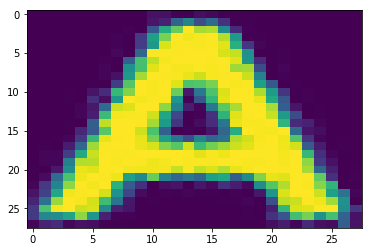

In [51]:
plt.imshow(b[0],aspect="auto")
plt.show()

## Checking the balance across the data

- The shape of each pickle is almost alike which will help to maintain the balance between the classes

In [53]:
file_name = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
for name in file_name:
    with open('/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small/{}.pickle'.format(name), 'rb') as handle:
        b = pickle.load(handle)
    print(b.shape)

(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


## Merging and pruning the data as required

In [65]:
from os import listdir
from os.path import isfile, join

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

mypath_train = '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large'
mypath_test = '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small'
onlyfiles_train = [join(mypath_train, f) for f in listdir(mypath_train) if isfile(join(mypath_train, f))]
onlyfiles_test = [join(mypath_test, f) for f in listdir(mypath_test) if isfile(join(mypath_test, f))]
onlyfiles_train = onlyfiles_train[1:]
onlyfiles_test = onlyfiles_test[1:]
print(onlyfiles_train)
print(onlyfiles_test)


['/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/A.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/B.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/C.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/D.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/E.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/F.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/G.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/H.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/I.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_large/J.pickle']
['/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small/A.pickle', '/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST_small/B.pickle', '/Users/jenkins/sleeba/dee

In [66]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
            if valid_dataset is not None:
                valid_letter = letter_set[:vsize_per_class, :, :]
                valid_dataset[start_v:end_v, :, :] = valid_letter
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class
                    
            train_letter = letter_set[vsize_per_class:end_l, :, :]
            train_dataset[start_t:end_t, :, :] = train_letter
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000


train_datasets = onlyfiles_train
test_datasets = onlyfiles_test
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## Randomize the trianing data to avoid crossing validation set and training set to be well distributed

In [67]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Understanding the dataset just generated

- Each row of `train_dataset` is the normalized pixel values of an image same as the above pickle
- Each label is mapped to a number from `0 to 10` to letters `A to J` respectively. That number is given in `train_labels`. The row numbers of `train_dataset` and `train_labels`
- Same is applicable for `test_dataset`, `test_labels` and `valid_dataset` , `valid_labels`

In [73]:
train_dataset.shape

(200000, 28, 28)

In [70]:
train_dataset[0]

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.49607843,
        -0.5       , -0.39019608,  0.43725491,  0.5       ,  0.49607843,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.49215686,  0.5       ,  0.5       ,
         0.49215686,  0.5       ,  0.20196079],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.49607843,
        -0.5       , -0.43333334, -0.24901961, -0.20980392, -0.06862745,
         0.34705883,  0.5       ,  0.49607843,  0.5       ,  0.5       ,
         0.5       ,  0.49215686,  0.5       ,  0.35882354,  0.00588235,
        -0.17450981, -0.21372549, -0.38627452],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5   

In [71]:
train_labels[0]

8

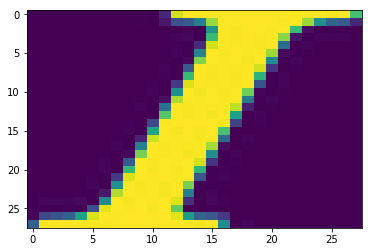

In [72]:
plt.imshow(train_dataset[0],aspect="auto")
plt.show()

## Saving the final data as a pickle

In [74]:
data_root = '/Users/jenkins/sleeba/deep_learning_udacity'

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [75]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Understanding the final pickle file

In [3]:
with open('/Users/jenkins/sleeba/deep_learning_udacity/not_mnist/notMNIST.pickle', 'rb') as handle:
    b = pickle.load(handle)

8


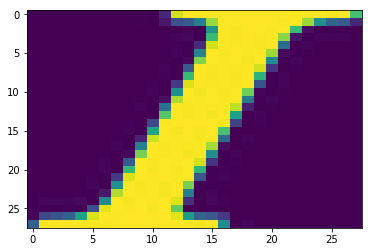

In [11]:
# print(b["train_dataset"][0])
print(b["train_labels"][0])
plt.imshow(b["train_dataset"][0],aspect="auto")
plt.show()

## Checking the overlap in the different data sets

In [12]:
len(np.unique(b["train_dataset"]))

256

### Checking common elements in `train_dataset` and `test_dataset`

In [15]:
b['train_dataset'].shape

(200000, 28, 28)

## Since the dataset is too big, randomly selecting 1000 images and looking for overlapping in examples

In [25]:
sample_train = b['train_dataset'][np.random.randint(b['train_dataset'].shape[0], size=1000), :]
sample_test = b['test_dataset'][np.random.randint(b['test_dataset'].shape[0], size=1000), :]

In [26]:
count = 0
for el in sample_train:
    for el2 in sample_test:
        if (el==el2).all():
            count+=1
            break
print(count)

10


`Here there is 10 samples with are exactly identical in training and testing datasets. This can be good or bad according to the application. If the letters are recurring in in your test case, then we don't need to remove the duplicates.`

In [28]:
sample_train = b['train_dataset'][np.random.randint(b['train_dataset'].shape[0], size=1000), :]
sample_test = b['test_dataset'][np.random.randint(b['test_dataset'].shape[0], size=1000), :]

In [29]:
count = 0
for el in sample_train:
    for el2 in sample_test:
        if np.allclose(el,el2):
            count+=1
            break
print(count)

5


`Here there is 5 samples with are almost identical in training and testing datasets. This can be good or bad according to the application. If the letters are recurring in in your test case, then we don't need to remove the duplicates.`

## Training a sample data set of 5000 using Logistic Regression model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [33]:
idx = np.random.choice(np.arange(len(b['train_dataset'])), 5000, replace=False)
x_sample = b['train_dataset'][idx]
y_sample = b['train_labels'][idx]

In [46]:
x_sample[0][0]

array([-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.36666667,  0.26078433,  0.47647059,
        0.49607843,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.49607843,  0.44509804,  0.19411765], dtype=float32)

In [62]:
train = x_sample.reshape((len(x_sample), -1))
label = y_sample

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.25, random_state=10)
model = LogisticRegression(verbose=10, n_jobs=-1, max_iter=200, )
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
predicted = model.predict(X_test)

In [65]:
print (metrics.accuracy_score(y_test, predicted))

0.792


# The Accuracy of the model is 79.2 % considering the random 5000 samples